## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data", 
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
prostate_train = prostate.drop("train", axis=1)[prostate["train"] == "T"]
prostate_test = prostate.drop("train", axis=1)[prostate["train"] == "F"]

In [4]:
# 标准化
scaler = StandardScaler().fit(prostate_train)
prostate_train_std = scaler.fit_transform(prostate_train)
prostate_test_std = scaler.transform(prostate_test)

X_train = prostate_train_std[:, :-1]
X_train = pd.DataFrame(X_train, index=prostate[prostate["train"] == "T"].index,
                       columns=prostate_train.iloc[:, :-1].columns)
y_train = prostate_train_std[:, -1]
X_test = prostate_test_std[:, :-1]
X_test = pd.DataFrame(X_test, index=prostate[prostate["train"] == "F"].index,
                       columns=prostate_test.iloc[:, :-1].columns)
y_test = prostate_test_std[:, -1]

## 最优子集选择

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import scipy.stats
import itertools

In [43]:
class BestSubsetSelection(BaseEstimator, RegressorMixin):
    """最优子集选择
    
    参数：
    -----
    k: 最优子集的数量
    W: 所选最优子集中每个特征的权重
    """
    def __init__(self, k=3):
        self.k = k
    
    def __least_squares_regression(self, X, y):
        lr = LinearRegression()
        lr.fit(X, y)
        y_pred = lr.predict(X)
        mse = mean_squared_error(y, y_pred)
        
        return mse
    
    def fit(self, X, y = None):
        mses = []
        features = []
        self.n_features = []
        for subset in itertools.combinations(X.columns, self.k):
            mse = self.__least_squares_regression(X[list(subset)], y)
            mses.append(mse)   
            features.append(subset)
            self.n_features.append(len(subset)) 
        self.mse = np.min(mses)
        self.feature = features[np.argmin(mses)]  # 找出误差最小的特征
        self.lr = LinearRegression()
        self.lr.fit(X[list(self.feature)], y)
        self.W = self.lr.coef_
        
        return self
 
    def predict(self, X):
        y_pred = self.lr.predict( X[list(self.feature)])
        return y_pred
    
    def print_fit_summary(self):
        print(self.model.summary())
        return self

In [44]:
bss = BestSubsetSelection(k=3) # 设定最优子集数量为3
bss.fit(X_train, y_train)

BestSubsetSelection()

In [45]:
y_pred = bss.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.363


In [46]:
y_pred = bss.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.279


In [48]:
print("所选择的子集：{}".format(bss.feature))

所选择的子集：('lcavol', 'lweight', 'svi')


### 选择最优参数

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
ks = np.arange(1, X_train.shape[1]+1)
param_grid = {'k': ks}
bss_cv = GridSearchCV(BestSubsetSelection(), 
                      param_grid=param_grid, 
                      cv=10, 
                      scoring='neg_mean_squared_error', 
                      return_train_score=True)
bss_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BestSubsetSelection(),
             param_grid={'k': array([1, 2, 3, 4, 5, 6, 7, 8])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
best_param = bss_cv.best_params_
print("最优子集的数量：{}".format(best_param['k']))

最优子集的数量：7


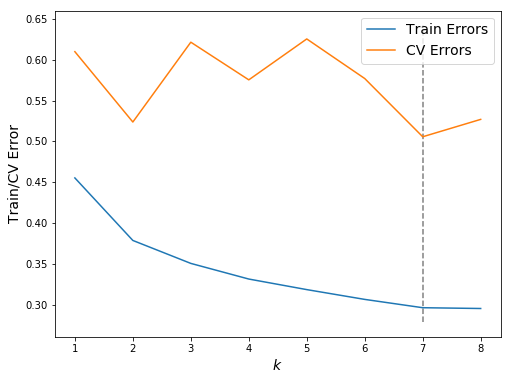

In [59]:
# 验证误差曲线
train_errs = -bss_cv.cv_results_['mean_train_score']
cv_errs = -bss_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(ks, train_errs, label="Train Errors")
plt.plot(ks, cv_errs, label="CV Errors")
plt.vlines(bss_cv.best_estimator_.k, 
           plt.ylim()[0], plt.ylim()[1],
           color="gray", linestyles="--")
plt.legend(fontsize=14)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Train/CV Error", fontsize=14)
plt.show()

### 使用最优模型

In [60]:
bss_best = bss_cv.best_estimator_

In [61]:
print("最优特征子集：{}".format(bss_best.feature))

最优特征子集：('lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45')


In [62]:
y_pred = bss_best.predict(X_train)
train_err = mean_squared_error(y_train, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [63]:
y_pred = bss_best.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.359


In [64]:
# 系数
pd.options.display.float_format = '{:.3f}'.format
variables = ["Intercept"] + list(bss_best.feature)
pd.DataFrame({"Term": variables, "Coefficient": np.r_[prostate_train.iloc[:, -1].mean(), 
                                                      bss_best.W]})

,Term,Coefficient
0,Intercept,2.452
1,lcavol,0.590
2,lweight,0.244
3,age,-0.121
4,lbph,0.175
5,svi,0.258
6,lcp,-0.238
7,pgg45,0.217
